# Miscellaneous set up

Load some packages

In [1]:
from itertools import product

import datetime
import pandas as pd
import numpy as np

from pandas.tseries.holiday import USFederalHolidayCalendar

from matplotlib import pyplot as plt
import seaborn as sns

import pymmwr

import jax
import glg


Functions to load data in standardized formats

In [3]:
def date_to_ew_str(row, date_col_name='wk_end_date'):
    ew = pymmwr.date_to_epiweek(datetime.date.fromisoformat(row[date_col_name]))
    # ew_str = pd.Series(str(ew.year) + str(ew.week))
    ew_str = str(ew.year) + str(ew.week)
    return ew_str



# convert epi week to season week
def convert_epiweek_to_season_week(epiweek):
  """Convert season and epiweek to season and season week.
  Args:
      epiweek in format 'yyyyww'
  Return:
      season_week: integer between 1 and 52
  """
  epiweek_year = epiweek.str[:4].astype(int)
  epiweek_week = epiweek.str[4:].astype(int)
  
  season_week = epiweek_week - 30

  update_inds = (season_week <= 0)
  season_week[update_inds] = season_week[update_inds] + \
    [pymmwr.epiweeks_in_year(int(epiweek_year[update_inds].values[i]) - 1) for i in range(np.sum(update_inds))]
  
  return season_week



def convert_epiweek_to_season(epiweek):
  """Convert season and epiweek to season and season week.
  Args:
      epiweek in format 'yyyyww'
  Return:
      season: string in format '2018/19'
  """
  epiweek_year = epiweek.str[:4].astype(int)
  epiweek_week = epiweek.str[4:].astype(int)
  
  update_inds = (epiweek_week <= 30)
  epiweek_year = epiweek_year - update_inds
  season = epiweek_year.astype(str)
  season = season + '/' + (season.str[-2:].astype(int) + 1).astype(str)
  
  return season



def load_flusurv_rates_2022_23():
    dat = pd.read_csv('../../data-raw/influenza-flusurv/flusurv-rates/flusurv-rates-2022-23.csv',
                  encoding='ISO-8859-1',
                  engine='python')
    dat.columns = dat.columns.str.lower()

    dat = dat.loc[(dat['age category'] == 'Overall') &
                  (dat['sex category'] == 'Overall') &
                  (dat['race category'] == 'Overall')]
    
    dat = dat.loc[~((dat.catchment == 'Entire Network') &
                    (dat.network != "FluSurv-NET"))]

    dat['location'] = dat['catchment']
    dat['agg_level'] = np.where(dat['location'] == 'Entire Network', 'national', 'site')
    dat['season'] = dat['year'].str.replace('-', '/')
    epiweek = dat['mmwr-year'].astype(str) + dat['mmwr-week'].astype(str)
    dat['season_week'] = convert_epiweek_to_season_week(epiweek)
    dat['wk_end_date'] = dat.apply(
        lambda x: pymmwr.epiweek_to_date(pymmwr.Epiweek(year=x['mmwr-year'],
                                                        week=x['mmwr-week'],
                                                        day=7))
                                            .strftime("%Y-%m-%d"),
        axis=1)
    dat['wk_end_date'] = pd.to_datetime(dat['wk_end_date'])
    dat['inc'] = dat['weekly rate ']
    dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
    
    return dat



def load_flusurv_rates_base(seasons=None,
                            locations=['California', 'Colorado', 'Connecticut', 'Entire Network',
                                      'Georgia', 'Maryland', 'Michigan', 'Minnesota', 'New Mexico',
                                      'New York - Albany', 'New York - Rochester', 'Ohio', 'Oregon',
                                      'Tennessee', 'Utah'],
                            age_labels=['0-4 yr', '5-17 yr', '18-49 yr', '50-64 yr', '65+ yr', 'Overall']
                            ):
  # read flusurv data and do some minimal preprocessing
  dat = pd.read_csv('../../data-raw/influenza-flusurv/flusurv-rates/old-flusurv-rates.csv',
                    encoding='ISO-8859-1',
                    engine='python')
  dat.columns = dat.columns.str.lower()
  dat['season'] = dat.sea_label.str.replace('-', '/')
  dat['inc'] = dat.weeklyrate
  dat['location'] = dat['region']
  dat['agg_level'] = np.where(dat['location'] == 'Entire Network', 'national', 'site')
  dat = dat[(dat.age_label.isin(age_labels)) & (dat.location.isin(locations))]
  if seasons is not None:
    dat = dat[dat.season.isin(seasons)]
  
  dat = dat.sort_values(by=['wk_end'])
  
  dat['wk_end_date'] = pd.to_datetime(dat['wk_end'])
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  
  dat = pd.concat(
    [dat, load_flusurv_rates_2022_23()],
    axis = 0
  )

  dat['source'] = 'flusurvnet'
  
  return dat


def load_one_us_census_file(f):
  dat = pd.read_csv(f, engine='python', dtype={'STATE': str})
  dat = dat.loc[(dat['NAME'] == 'United States') | (dat['STATE'] != '00'),
                (dat.columns == 'STATE') | (dat.columns.str.startswith('POPESTIMATE'))]
  dat = dat.melt(id_vars = 'STATE', var_name='season', value_name='pop')
  dat.rename(columns={'STATE': 'location'}, inplace=True)
  dat.loc[dat['location'] == '00', 'location'] = 'US'
  dat['season'] = dat['season'].str[-4:]
  dat['season'] = dat['season'] + '/' + (dat['season'].str[-2:].astype(int) + 1).astype(str)
  
  return dat


def load_us_census():
  files = [
    '../../data-raw/us-census/nst-est2019-alldata.csv',
    '../../data-raw/us-census/NST-EST2022-ALLDATA.csv']
  dat = pd.concat([load_one_us_census_file(f) for f in files], axis=0)
  
  return dat


def load_hosp_burden():
  burden_estimates = pd.read_csv(
    '../../data-raw/burden-estimates/burden-estimates.csv',
    engine='python')

  burden_estimates.columns = ['season', 'hosp_burden']

  #burden_estimates['hosp_burden'] = burden_estimates['hosp_burden'].astype(int)

  burden_estimates['season'] = burden_estimates['season'].str[:4] + '/' + burden_estimates['season'].str[7:9]

  return burden_estimates


def calc_hosp_burden_adj():
  dat = load_flusurv_rates_base(
    seasons = ['20' + str(yy) + '/' + str(yy+1) for yy in range(10, 23)],
    locations= ['Entire Network'],
    age_labels = ['Overall']
  )

  burden_adj = dat[dat.location == 'Entire Network'] \
    .groupby('season')['inc'] \
    .sum()
  burden_adj = burden_adj.reset_index()
  burden_adj.columns = ['season', 'cum_rate']

  us_census = load_us_census().query("location == 'US'").drop('location', axis=1)
  burden_adj = pd.merge(burden_adj, us_census, on='season')

  burden_estimates = load_hosp_burden()
  burden_adj = pd.merge(burden_adj, burden_estimates, on='season')

  burden_adj['reported_burden_est'] = burden_adj['cum_rate'] * burden_adj['pop'] / 100000
  burden_adj['adj_factor'] = burden_adj['hosp_burden'] / burden_adj['reported_burden_est']

  return burden_adj


def fill_missing_flusurv_dates_one_location(location_df):
  df = location_df.set_index('wk_end_date') \
    .asfreq('W-sat') \
    .reset_index()
  fill_cols = ['agg_level', 'location', 'season', 'pop', 'source']
  df[fill_cols] = df[fill_cols].fillna(axis=0, method='ffill')
  return df


def load_flusurv_rates(burden_adj=True,
                       locations=['California', 'Colorado', 'Connecticut', 'Entire Network',
                                'Georgia', 'Maryland', 'Michigan', 'Minnesota', 'New Mexico',
                                'New York - Albany', 'New York - Rochester', 'Ohio', 'Oregon',
                                'Tennessee', 'Utah']
                       ):
  # read flusurv data and do some minimal preprocessing
  dat = load_flusurv_rates_base(
    seasons = ['20' + str(yy) + '/' + str(yy+1) for yy in range(10, 23)],
    locations = locations,
    age_labels = ['Overall']
  )
  
  # if requested, make adjustments for overall season burden
  if burden_adj:
    hosp_burden_adj = calc_hosp_burden_adj()
    dat = pd.merge(dat, hosp_burden_adj, on='season')
    dat['inc'] = dat['inc'] * dat['adj_factor']
  
  # fill in missing dates
  gd = dat.groupby('location')
  
  dat = pd.concat(
    [fill_missing_flusurv_dates_one_location(df) for _, df in gd],
    axis = 0)
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc', 'source']]
  
  return dat


def load_who_nrevss_positive():
  dat = pd.read_csv('../../data-raw/influenza-who-nrevss/who-nrevss.csv',
                    encoding='ISO-8859-1',
                    engine='python')
  dat = dat[['region_type', 'region', 'year', 'week', 'season', 'season_week', 'percent_positive']]
  
  dat.rename(columns={'region_type': 'agg_level', 'region': 'location'},
             inplace=True)
  dat['agg_level'] = np.where(dat['agg_level'] == 'National',
                              'national',
                              dat['agg_level'].str[:-1].str.lower())
  return dat


def load_ilinet(response_type='rate',
                scale_to_positive=True,
                drop_pandemic_seasons=True,
                burden_adj=False):
  # read ilinet data and do some minimal preprocessing
  files = ['../../data-raw/influenza-ilinet/ilinet.csv',
           '../../data-raw/influenza-ilinet/ilinet_hhs.csv',
           '../../data-raw/influenza-ilinet/ilinet_state.csv']
  dat = pd.concat(
    [ pd.read_csv(f, encoding='ISO-8859-1', engine='python') for f in files ],
    axis = 0)
  
  if response_type == 'rate':
    dat['inc'] = np.where(dat['region_type'] == 'States',
                          dat['unweighted_ili'],
                          dat['weighted_ili'])
  else:
    dat['inc'] = dat.ilitotal

  dat['wk_end_date'] = pd.to_datetime(dat['week_start']) + pd.Timedelta(6, 'days')
  dat = dat[['region_type', 'region', 'year', 'week', 'season', 'season_week', 'wk_end_date', 'inc']]
  
  dat.rename(columns={'region_type': 'agg_level', 'region': 'location'},
             inplace=True)
  dat['agg_level'] = np.where(dat['agg_level'] == 'National',
                              'national',
                              dat['agg_level'].str[:-1].str.lower())
  dat = dat.sort_values(by=['season', 'season_week'])
  
  # for early seasons, drop out-of-season weeks with no reporting
  early_seasons = [str(yyyy) + '/' + str(yyyy + 1)[2:] for yyyy in range(1997, 2002)]
  early_in_season_weeks = [w for w in range(10, 43)]
  first_report_season = ['2002/03']
  first_report_in_season_weeks = [w for w in range(10, 53)]
  dat = dat[
    (dat.season.isin(early_seasons) & dat.season_week.isin(early_in_season_weeks)) |
    (dat.season.isin(first_report_season) & dat.season_week.isin(first_report_in_season_weeks)) |
    (~dat.season.isin(early_seasons + first_report_season))]
  
  # region 10 data prior to 2010/11 is bad, drop it
  dat = dat[
    ~((dat['location'] == 'Region 10') & (dat['season'] < '2010/11'))
  ]
  
  if scale_to_positive:
    dat = pd.merge(
      left=dat,
      right=load_who_nrevss_positive(),
      how='left',
      on=['agg_level', 'location', 'season', 'season_week'])
    dat['inc'] = dat['inc'] * dat['percent_positive'] / 100.0
    dat.drop('percent_positive', axis=1)

  if drop_pandemic_seasons:
    dat.loc[dat['season'].isin(['2008/09', '2009/10', '2020/21', '2021/22']), 'inc'] = np.nan

  # if requested, make adjustments for overall season burden
  # if burden_adj:
  #   hosp_burden_adj = calc_hosp_burden_adj()
  #   dat = pd.merge(dat, hosp_burden_adj, on='season')
  #   dat['inc'] = dat['inc'] * dat['adj_factor']

  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  dat['source'] = 'ilinet'
  return dat



def load_hhs(rates=True):
  dat = pd.read_csv("../../data-raw/influenza-hhs/hhs.csv")
  dat.rename(columns={'date': 'wk_end_date'}, inplace=True)

  ew_str = dat.apply(date_to_ew_str, axis=1)
  dat['season'] = convert_epiweek_to_season(ew_str)
  dat['season_week'] = convert_epiweek_to_season_week(ew_str)
  dat = dat.sort_values(by=['season', 'season_week'])
  
  if rates:
    pops = load_us_census()
    dat = dat.merge(pops, on = ['location', 'season'], how='left') \
      .assign(inc=lambda x: x['inc'] / x['pop'] * 100000)

  dat['wk_end_date'] = pd.to_datetime(dat['wk_end_date'])
  
  dat['agg_level'] = np.where(dat['location'] == 'US', 'national', 'state')
  dat = dat[['agg_level', 'location', 'season', 'season_week', 'wk_end_date', 'inc']]
  dat['source'] = 'hhs'
  return dat



def get_season_hol(start_year):
  holiday_cal = USFederalHolidayCalendar()
  hol = holiday_cal.holidays(
    start=datetime.datetime(year=start_year, month=7, day=1),
    end=datetime.datetime(year=start_year+1, month=6, day=1),
    return_name=True)
    
  hol = hol.reset_index()
  hol.columns = ['date', 'holiday']
  hol = hol.loc[hol['holiday'].isin(['Thanksgiving', 'Christmas'])]
  
  hol['season'] = str(start_year) + '/' + str(start_year + 1)[-2:]
  
  return hol



def convert_datetime_to_season_week(row, date_col_name):
  ew = pymmwr.date_to_epiweek(row[date_col_name].date())
  ew_str = pd.Series(str(ew.year) + str(ew.week))
  return convert_epiweek_to_season_week(ew_str)



def get_holidays():
  hol = pd.concat([get_season_hol(sy) for sy in range(1997, 2024)],
                  ignore_index=True)
  hol['season_week'] = hol.apply(convert_datetime_to_season_week, axis=1, date_col_name='date')
  
  return hol[['season', 'holiday', 'date', 'season_week']]


In [4]:
holidays = get_holidays()
holidays

,season,holiday,date,season_week
0,1997/98,Thanksgiving,1997-11-27,18
1,1997/98,Christmas,1997-12-25,22
2,1998/99,Thanksgiving,1998-11-26,17
3,1998/99,Christmas,1998-12-25,21
4,1999/00,Thanksgiving,1999-11-25,17
5,1999/00,Christmas,1999-12-24,21
6,2000/01,Thanksgiving,2000-11-23,17
7,2000/01,Christmas,2000-12-25,22
8,2001/02,Thanksgiving,2001-11-22,17
9,2001/02,Christmas,2001-12-25,22


# ILINet and WHO/NREVSS Virology data

Here we conduct a similar analysis as above, but obtaining measures of influenza prevalence from the ILINet system and using virology testing data from WHO/NREVSS to construct a proxy measure of incidence due to influenza A/H1, A/H3, and B. The ILINet data give us two measures of the prevalence of influenza in each week: (1) a proportion of outpatient doctor visits where the patient has symptoms consistent with influenza-like illness, and (2) a count of the number of outpatient doctor visits where the patient has symptoms consistent with influenza-like illness. When calculating the proportion, rates are weighted by state population when aggregating to the national level. These population-adjusted rates are perhaps a better summary of the national level signal, but it appears that Goldstein et al. analyzed the counts. We examine each signal in turn.

## ILINet rates

Here is a plot of the raw ILInet data at the national level, by season.

In [5]:
ilinet_dat = load_ilinet()
ilinet_dat

,agg_level,location,season,season_week,wk_end_date,inc,source
0,national,National,1997/98,10,1997-10-04,0.0,ilinet
1,hhs region,Region 1,1997/98,10,1997-10-04,0.0,ilinet
2,hhs region,Region 2,1997/98,10,1997-10-04,0.0,ilinet
3,hhs region,Region 3,1997/98,10,1997-10-04,0.0,ilinet
4,hhs region,Region 4,1997/98,10,1997-10-04,0.0,ilinet
...,...,...,...,...,...,...,...
49828,state,Wyoming,2023/24,8,2023-09-23,NaN,ilinet
49829,state,Commonwealth of the Northern Mariana Islands,2023/24,8,2023-09-23,NaN,ilinet
49830,state,Puerto Rico,2023/24,8,2023-09-23,0.0,ilinet
49831,state,Virgin Islands,2023/24,8,2023-09-23,NaN,ilinet


In [6]:
ilinet_nat = ilinet_dat.loc[(ilinet_dat['agg_level'] == "national") &
                            (ilinet_dat['season_week'] >= 10) &
                            (ilinet_dat['season_week'] <= 45)] \
    .dropna()
ilinet_nat['season_factor'] = pd.factorize(ilinet_nat['season'])[0]
ilinet_nat['season_week_factor'] = pd.factorize(ilinet_nat['season_week'])[0]


In [7]:
ilinet_nat['season'].unique()

array(['1997/98', '1998/99', '1999/00', '2000/01', '2001/02', '2002/03',
       '2003/04', '2004/05', '2005/06', '2006/07', '2007/08', '2010/11',
       '2011/12', '2012/13', '2013/14', '2014/15', '2015/16', '2016/17',
       '2017/18', '2018/19', '2019/20', '2022/23'], dtype=object)

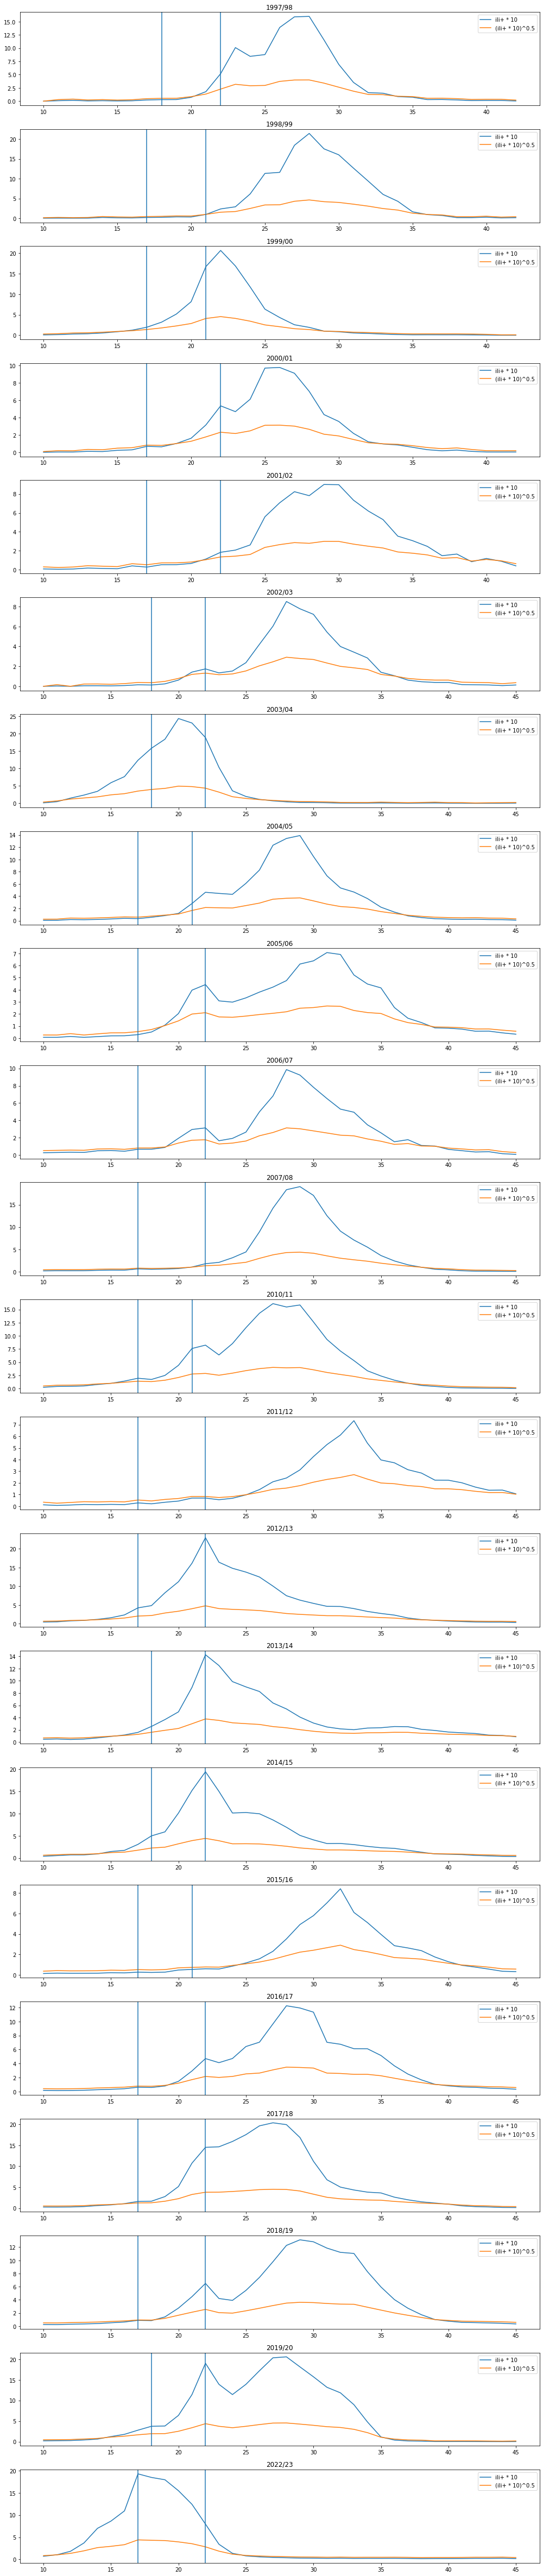

In [8]:
n_seasons = len(ilinet_nat['season'].unique())
fig, ax = plt.subplots(n_seasons, 1, figsize = (14, 3*n_seasons))

for i, season in enumerate(ilinet_nat['season'].unique()):
    season_dat = ilinet_nat.loc[ilinet_nat['season'] == season]
    ax[i].plot(season_dat['season_week'], season_dat['inc']*10, label = 'ili+ * 10')
    ax[i].plot(season_dat['season_week'], (season_dat['inc']*10)**0.5, label = '(ili+ * 10)^0.5')
    
    hol = holidays.loc[holidays['season'] == season]
    
    for hol_name in ['Thanksgiving', 'Christmas']:
        hol_week = hol.loc[hol['holiday'] == hol_name, 'season_week'].values[0]
        ax[i].axvline(hol_week)
    
    ax[i].set_title(season)
    ax[i].legend()

fig.tight_layout()

In [9]:
ilinet_nat

,agg_level,location,season,season_week,wk_end_date,inc,source,season_factor,season_week_factor
0,national,National,1997/98,10,1997-10-04,0.000000,ilinet,0,0
10,national,National,1997/98,11,1997-10-11,0.008725,ilinet,0,1
20,national,National,1997/98,12,1997-10-18,0.015102,ilinet,0,2
30,national,National,1997/98,13,1997-10-25,0.005030,ilinet,0,3
40,national,National,1997/98,14,1997-11-01,0.008731,ilinet,0,4
...,...,...,...,...,...,...,...,...,...
48524,national,National,2022/23,41,2023-05-13,0.019596,ilinet,21,31
48590,national,National,2022/23,42,2023-05-20,0.022221,ilinet,21,32
48656,national,National,2022/23,43,2023-05-27,0.021989,ilinet,21,33
48722,national,National,2022/23,44,2023-06-03,0.024227,ilinet,21,34


In [16]:
w_xmas_df = ilinet_nat[['season', 'season_factor']] \
    .drop_duplicates() \
    .merge(holidays.loc[holidays['holiday'] == 'Christmas'],
           on='season',
           how='left') \
    .rename(columns={'season_week': 'w_xmas'})

w_xmas = w_xmas_df['w_xmas'].values

w_xmas

array([22, 21, 21, 22, 22, 22, 22, 21, 22, 22, 22, 21, 22, 22, 22, 22, 21,
       22, 22, 22, 22, 22])

In [11]:
#import importlib
#importlib.reload(glg)

#transforms = [None, 'sqrt', '4rt']
transforms = [None, 'sqrt']
# transforms = ['sqrt', '4rt']
# transforms = [None]

glg_models = {
    transform: glg.GLG(num_seasons=len(ilinet_nat['season'].unique()),
                       num_season_weeks=len(ilinet_nat['season_week'].unique()),
                       xmas_half_window=2,
                       transform=transform) \
        for transform in transforms }

mcmc_samples = {
    transform: glg_models[transform].fit(y=ilinet_nat['inc'].values,
                                         s=ilinet_nat['season_factor'].values,
                                         w=ilinet_nat['season_week_factor'].values,
                                         w_xmas=w_xmas-10,
                                         rng_key=jax.random.PRNGKey(937483)) \
        for transform in transforms }

sample: 100%|██████████| 2000/2000 [01:14<00:00, 26.86it/s, 511 steps of size 1.95e-02. acc. prob=0.90] 



MCMC elapsed time: 81.57060194015503


sample: 100%|██████████| 2000/2000 [00:36<00:00, 55.24it/s, 255 steps of size 3.34e-02. acc. prob=0.92]



MCMC elapsed time: 36.9572229385376


In [24]:
jnp.mean(mcmc_samples['sqrt']['xmas_mean_effect'], axis=0)

Array([ 0.04794357,  0.12037699,  0.18996301,  0.09104492, -0.00896828],      dtype=float32)

In [25]:
jnp.mean(mcmc_samples[None]['xmas_mean_effect'], axis=0)

Array([0.08791333, 0.21174334, 0.3670093 , 0.20740815, 0.0375356 ],      dtype=float32)

In [18]:
test_values = pd.DataFrame.from_records(product(
    ilinet_nat['season_factor'].unique(),
    ilinet_nat['season_week_factor'].unique()))
test_values.columns = ['season_factor', 'season_week_factor']
test_values['season_week'] = test_values['season_week_factor'] + 10
test_values = test_values.merge(
    w_xmas_df[['season_factor', 'w_xmas']],
    on='season_factor',
    how='left')


for transform in transforms:
    post_samples = glg_models[transform].sample(
        rng_key=jax.random.PRNGKey(853),
        s = test_values['season_factor'].values,
        w = test_values['season_week_factor'].values,
        w_xmas = w_xmas - 10,
        condition = mcmc_samples[transform])
    
    if transform is None:
        transform_text = 'no_transform'
    else:
        transform_text = transform
    
    test_values[f'mean_{transform_text}'] = np.mean(post_samples['y'], axis=0)
    test_values[f'median_{transform_text}'] = np.median(post_samples['y'], axis=0)
    test_values[f'q025_{transform_text}'] = np.percentile(post_samples['y'], q=2.5, axis=0)
    test_values[f'q10_{transform_text}'] = np.percentile(post_samples['y'], q=10, axis=0)
    test_values[f'q25_{transform_text}'] = np.percentile(post_samples['y'], q=25, axis=0)
    test_values[f'q75_{transform_text}'] = np.percentile(post_samples['y'], q=75, axis=0)
    test_values[f'q90_{transform_text}'] = np.percentile(post_samples['y'], q=90, axis=0)
    test_values[f'q975_{transform_text}'] = np.percentile(post_samples['y'], q=97.5, axis=0)



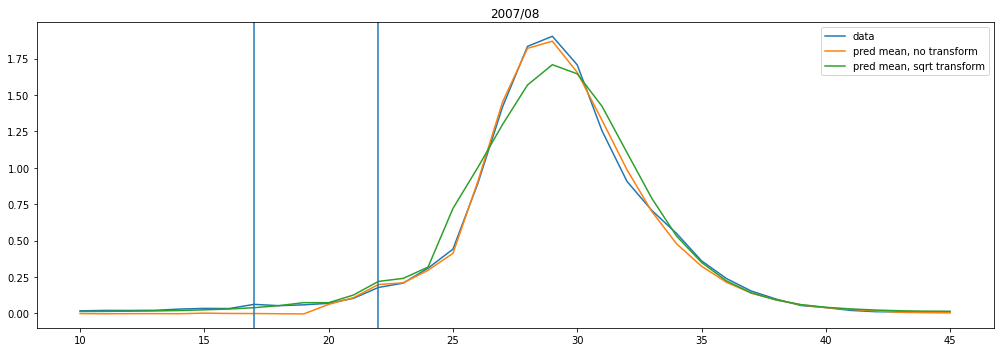

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (14, 5*1))

i = 0
season_factor = 10

season_dat = ilinet_nat.loc[ilinet_nat['season_factor'] == season_factor]
season = season_dat['season'].values[0]
ax.plot(season_dat['season_week'], season_dat['inc'], label = 'data')

season_pred = test_values.loc[test_values['season_factor'] == season_factor]
ax.plot(season_pred['season_week'], season_pred['mean_no_transform'], label = 'pred mean, no transform')
ax.plot(season_pred['season_week'], season_pred['mean_sqrt'], label = 'pred mean, sqrt transform')
# ax.plot(season_pred['season_week'], season_pred['mean_4rt'], label = 'pred mean, 4rt transform')

hol = holidays.loc[holidays['season'] == season]

for hol_name in ['Thanksgiving', 'Christmas']:
    hol_week = hol.loc[hol['holiday'] == hol_name, 'season_week'].values[0]
    ax.axvline(hol_week)

ax.set_title(season)
ax.legend()

fig.tight_layout()

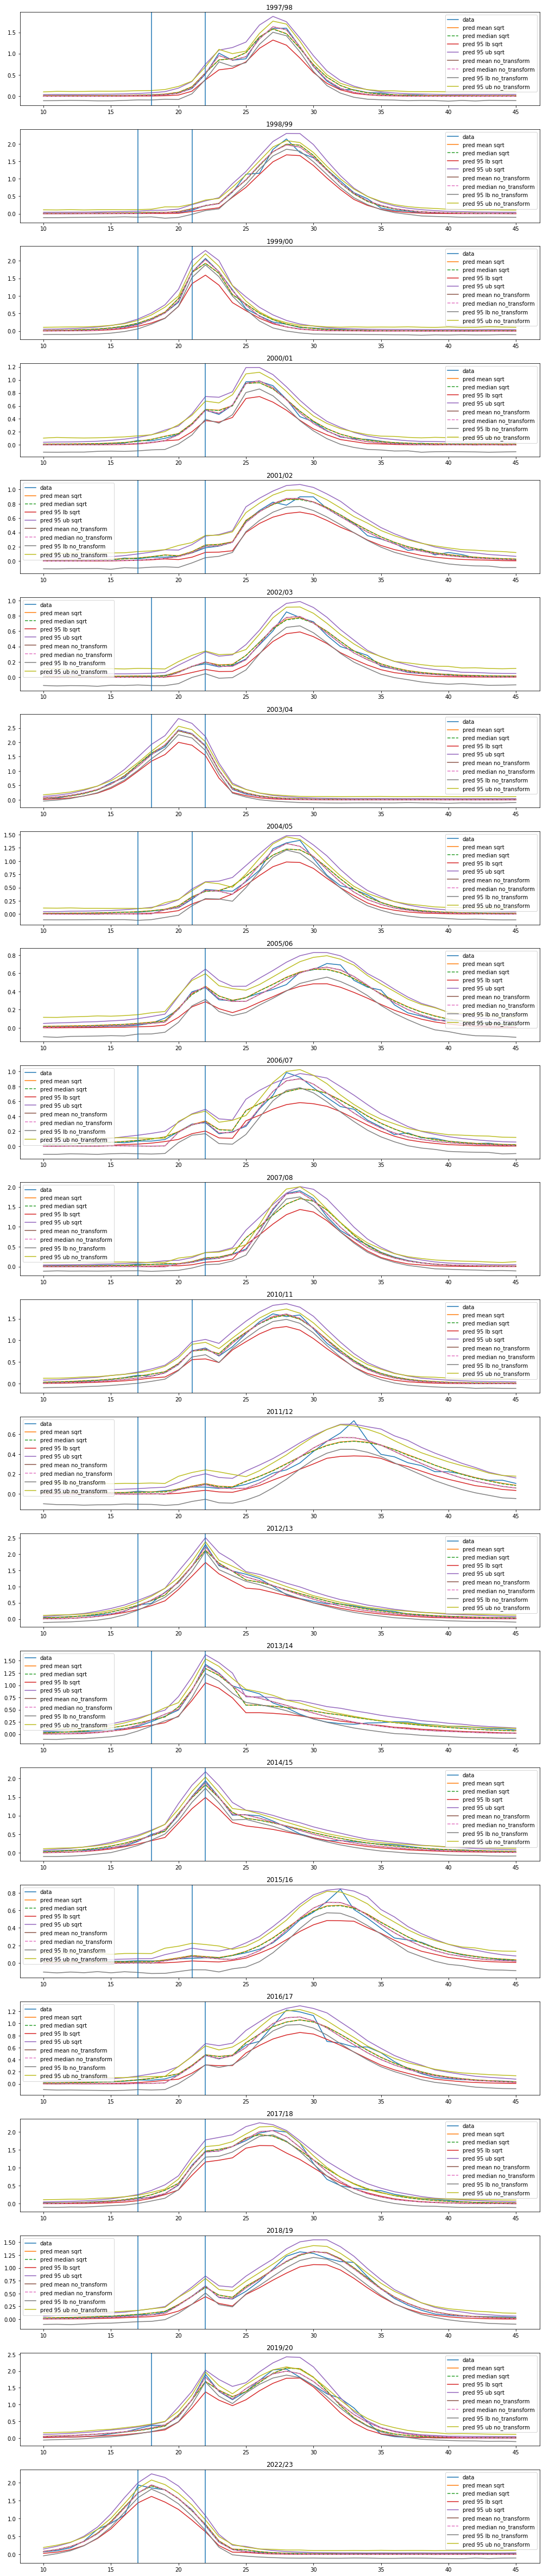

In [21]:
n_seasons = len(ilinet_nat['season_factor'].unique())
# n_seasons = 1
fig, ax = plt.subplots(n_seasons, 1, figsize = (14, 3*n_seasons))

for i, season_factor in enumerate(ilinet_nat['season_factor'].unique()):
    season_dat = ilinet_nat.loc[ilinet_nat['season_factor'] == season_factor]
    season = season_dat['season'].values[0]
    ax[i].plot(season_dat['season_week'], season_dat['inc'], label = 'data')
    
    for transform_text in ['sqrt', 'no_transform']:
    # for transform_text in ['sqrt', '4rt']:
    # for transform_text in ['no_transform']:
        season_pred = test_values.loc[test_values['season_factor'] == season_factor]
        ax[i].plot(season_pred['season_week'], season_pred[f'mean_{transform_text}'], label = f'pred mean {transform_text}')
        ax[i].plot(season_pred['season_week'], season_pred[f'median_{transform_text}'], label = f'pred median {transform_text}',
                linestyle='dashed')
        ax[i].plot(season_pred['season_week'], season_pred[f'q025_{transform_text}'], label = f'pred 95 lb {transform_text}')
        ax[i].plot(season_pred['season_week'], season_pred[f'q975_{transform_text}'], label = f'pred 95 ub {transform_text}')
        
    hol = holidays.loc[holidays['season'] == season]
    
    for hol_name in ['Thanksgiving', 'Christmas']:
        hol_week = hol.loc[hol['holiday'] == hol_name, 'season_week'].values[0]
        ax[i].axvline(hol_week)
    
    ax[i].set_title(season)
    ax[i].legend()

fig.tight_layout()